# (기본-1) Object Detection
### 과제 개요
1. 강의 시간에 다뤘던 detection metric 중 하나인 mAP 구현을 학습합니다.
2. 오픈소스 라이브러리를 활용하여 쉽게 mAP 를 구현합니다.
3. 오픈소스 라이브러리에 도움 없이 밑바닥에서부터 mAP를 구현합니다.


### 과제 출제 목적 및 배경
Object detection 태스크에서 성능을 평가하는 다양한 metric이 존재합니다. 그 중 mAP를 많이 활용하는데요. 오픈소스 라이브러리를 활용하여, sample submission 을 활용해 mAP를 계산하는 코드를 작성해봅시다.

### 과제 수행으로 얻을 수 있는 역량  
* 추후에 있을 대회 데이터셋을 활용하여 오픈소스 라이브러리를 통해서 쉽게 mAP를 계산하는 코드를 구현할 수 있습니다. torch로 naive하게 구현함으로써 현업에서의 다양한 상황에 맞게 응용력을 키울 수 있습니다.  
* numpy를 이용하여, 밑바닥에서부터 오픈소스 라이브러리에 도움없이 코드를 구현할 수 있습니다.
* 밑바닥에서 부터 코드를 구현함으로써 mAP에 대해 더욱 직관적으로 이해할 수 있습니다.

### 순서  
1. 오픈소스 라이브러리를 이용한 mAP 구현
- pycocotools, map_boxes를 이용한 구현
2. 밑바닥에터 mAP 구현
- numpy를 이용한 구현


> **ANSWER HERE** 이라고 작성된 부분을 채워 완성하시면 됩니다. 다른 부분의 코드를 변경하면 오류가 발생할 수 있습니다.

#### mAP Metric
<br>mAP의 자세한 내용은 01강: Object Detection overview 강의를 참고합니다.

## 대회 데이터셋 구성
Custom 데이터를 구현하여 대회 데이터셋에 mAP를 계산해봅시다. <br>
코드를 이용하여 데이터셋을 다운받아줍니다
**wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000266/data/data.tar.gz**

데이터셋의 자세한 개요는 [대회 플랫폼](https://stages.ai/competitions/325/data/overview)의 데이터 설명을 참고합니다.
> Copyright: CC BY 2.0

### dataset
    ├── train.json
    ├── test.json
    ├── train
    └── test

### 필요 패키지 import

In [1]:
!pip install map_boxes==1.0.5
!pip install numpy==1.22.2
!pip install tqdm==4.65.0
!pip install pycocotools==2.0.6

  Using cached numpy-1.22.2.zip (11.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "C:\Users\zin\anaconda3\envs\p312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Users\zin\anaconda3\envs\p312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\zin\anaconda3\envs\p312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
        File "C:\Users\zin\anaconda3\envs\p312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_

In [2]:
pip install --no-deps numpy==1.22.2

  Using cached numpy-1.22.2.zip (11.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "c:\Users\zin\anaconda3\envs\p312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\zin\anaconda3\envs\p312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\zin\anaconda3\envs\p312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
        File "c:\Users\zin\anaconda3\envs\p312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_

In [3]:
from map_boxes import mean_average_precision_for_boxes
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [4]:
'''
    GT_JSON: valid set json file path
    현재 예시에서는 train.json을 임의로 valid set으로 사용
    PRED_CSV: 위의 valid set을 inference한 submission file
'''
GT_JSON = '../../dataset/train.json'
PRED_CSV = '../sample_submission/train_sample.csv'
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal",
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

# load ground truth
with open(GT_JSON, 'r') as outfile:
    test_anno = (json.load(outfile))

# load prediction
pred_df = pd.read_csv(PRED_CSV)

In [5]:
'''
[
    [file_name label_index confidence_score x_min x_max y_min y_max],
    [file_name label_index confidence_score x_min x_max y_min y_max],
    ,,,
    [file_name label_index confidence_score x_min x_max y_min y_max]
]

이는 아래의 mean_average_precision_for_boxes 함수에 들어갈 양식입니다.
new_pred가 위와 같은 format을 갖도록, submission.csv를 가공해봅시다.
'''

new_pred = []

file_names = pred_df['image_id'].values.tolist()
bboxes = pred_df['PredictionString'].values.tolist()

'''
create new_pred
'''

# check variable type
for i, bbox in enumerate(bboxes):
    if isinstance(bbox, float):
        print(f'{file_names[i]} empty box')

for file_name, bbox in tqdm(zip(file_names, bboxes)):
    boxes = np.array(str(bbox).strip().split(' '))

    # boxes - class ID confidence score xmin ymin xmax ymax
    if len(boxes) % 6 == 0:
        boxes = boxes.reshape(-1, 6)
    elif isinstance(bbox, float):
        print(f'{file_name} empty box')
        continue
    else:
        raise Exception('error', 'invalid box count')
    for box in boxes:
        new_pred.append([file_name, box[0], box[1], float(box[2]), float(box[4]), float(box[3]), float(box[5])])
        # print(box)

4883it [00:01, 4572.10it/s]


In [6]:
bboxes

['0 0.7978816628456116 183.583740234375 204.7623748779297 757.228759765625 663.2476196289062 0 0.30007776618003845 294.1588134765625 428.72027587890625 712.8113403320312 662.5757446289062 9 0.27576687932014465 187.20274353027344 199.62417602539062 785.662109375 664.3910522460938 0 0.13876120746135712 360.568359375 198.63479614257812 678.2484741210938 474.7105712890625 1 0.09028089046478271 222.17236328125 184.7045135498047 727.7378540039062 673.251708984375 9 0.07502871006727219 363.07427978515625 200.3661651611328 688.6143798828125 481.45367431640625 0 0.07456113398075104 203.72471618652344 370.8855285644531 483.5150146484375 544.1288452148438 ',
 '1 0.6951920390129089 125.23683166503906 0.0 1006.5919799804688 468.480224609375 3 0.4558187425136566 726.529296875 315.93035888671875 991.1689453125 549.9341430664062 0 0.44687315821647644 90.01470184326172 460.6448974609375 143.81053161621094 508.76708984375 3 0.40141531825065613 152.197998046875 459.5503845214844 793.1329345703125 695.134

In [7]:
'''
[
    [file_name 1, label_index, x_min, x_max, y_min, y_max],
    [file_name 2, label_index, x_min, x_max, y_min, y_max],
    ,,,
    [file_name , label_index, x_min, x_max, y_min, y_max]
]

아래의 mean_average_precision_for_boxes 함수에 들어갈 양식, gt 양식
'''

gt = []


'''
coco.getImgIds(): return image id list

coco.loadImgs(image_id): return image_info

image_info['file_name']: return file name

coco.getAnnIds(imgIds=image_info['id']): return annotation id

coco.loadAnns(ann_ids): return annotation information list (annotation_info_list)

annotation_info_list[i]['bbox']: return i'th annotation [x_min, y_min, w, h]

annotation_info_list[i]['category_id']: return i'th annotation category

'''
#image_id = coco.getImgIds()

coco = COCO(GT_JSON)

'''
create gt
: image id 별로 GT 값 추가
'''
for image_id in coco.getImgIds():
    ### YOUR CODE HERE
    ### ANSWER HERE ###
    # 구현해야 할 변수 : image_info, annotation_id, annotation_info_list
      # image_info: coco.
      # annotation_id: coco.
      # annotation_info_list: coco.
    ### END YOUR CODE
    image_info = coco.loadImgs(image_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)

    file_name = image_info['file_name']

    for annotation in annotation_info_list:
        gt.append([file_name, annotation['category_id'],
                   float(annotation['bbox'][0]),
                   float(annotation['bbox'][0]) + float(annotation['bbox'][2]),
                   float(annotation['bbox'][1]),
                   (float(annotation['bbox'][1]) + float(annotation['bbox'][3]))])

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [8]:
'''
calculate mAP
'''

mean_ap, average_precisions = mean_average_precision_for_boxes(gt, new_pred, iou_threshold=0.5)

print(mean_ap)

Number of files in annotations: 4883
Number of files in predictions: 4883
Unique classes: 10
Detections length: 4883
Annotations length: 4883
0                              | 0.264624 |    3966
1                              | 0.522890 |    6352
2                              | 0.441265 |     897
3                              | 0.411529 |     936
4                              | 0.604017 |     982
5                              | 0.397688 |    2943
6                              | 0.490678 |    1263
7                              | 0.722987 |    5178
8                              | 0.599785 |     159
9                              | 0.531735 |     468
mAP: 0.498720
0.49871974228579613


In [9]:
'''
이번 미션에서는 train.json을 이용했지만, 실제 컴피티션에서는 validation set에 대한 모델의 성능을 측정, 트래킹하는 것이 중요합니다.
validation.json을 만들어, mAP를 계산, 모델의 성능을 측정해봅시다.

또한, 심화 미션은 라이브러리를 이용하지 않고, mean_average_precision_for_boxes 함수를 구현하는 것입니다.
도전해볼까요?
'''


'\n이번 미션에서는 train.json을 이용했지만, 실제 컴피티션에서는 validation set에 대한 모델의 성능을 측정, 트래킹하는 것이 중요합니다.\nvalidation.json을 만들어, mAP를 계산, 모델의 성능을 측정해봅시다.\n\n또한, 심화 미션은 라이브러리를 이용하지 않고, mean_average_precision_for_boxes 함수를 구현하는 것입니다.\n도전해볼까요?\n'

### numpy를 이용한 구현

In [10]:
'''
    GT_JSON: valid set json file path
    현재 예시에서는 train.json을 임의로 valid set으로 사용
    PRED_CSV: 위의 valid set을 inference한 submission file
'''
GT_JSON = '../../dataset/train.json'
PRED_CSV = '../sample_submission/train_sample.csv'
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal",
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]


# load ground truth
with open(GT_JSON, 'r') as outfile:
    test_anno = (json.load(outfile))

# load prediction
pred_df = pd.read_csv(PRED_CSV)

In [11]:
'''
[
    [file_name label_index confidence_score x_min x_max y_min y_max],
    [file_name label_index confidence_score x_min x_max y_min y_max],
    ,,,
    [file_name label_index confidence_score x_min x_max y_min y_max]
]

이는 아래의 mean_average_precision_for_boxes 함수에 들어갈 양식입니다.
new_pred가 위와 같은 format을 갖도록, submission.csv를 가공해봅시다.
'''

new_pred = []

file_names = pred_df['image_id'].values.tolist()
bboxes = pred_df['PredictionString'].values.tolist()

'''
create new_pred
'''

for i, bbox in enumerate(bboxes):
    if isinstance(bbox, float):
        print(f'{file_names[i]} empty box')

for file_name, bbox in tqdm(zip(file_names, bboxes)):
    boxes = np.array(str(bbox).strip().split(' '))

    if len(boxes) % 6 == 0:
        boxes = boxes.reshape(-1, 6)
    elif isinstance(bbox, float):
        print(f'{file_name} empty box')
        continue
    else:
        raise Exception('error', 'invalid box count')
    for box in boxes:
        new_pred.append([file_name, box[0], box[1], float(box[2]), float(box[4]), float(box[3]), float(box[5])])

4883it [00:01, 4431.04it/s]


In [12]:
'''
[
    [file_name 1, label_index, x_min, x_max, y_min, y_max],
    [file_name 2, label_index, x_min, x_max, y_min, y_max],
    ,,,
    [file_name , label_index, x_min, x_max, y_min, y_max]
]

아래의 mean_average_precision_for_boxes 함수에 들어갈 양식, gt 양식
'''

gt = []


'''
coco.getImgIds(): return image id list

coco.loadImgs(image_id): return image_info

image_info['file_name']: return file name

coco.getAnnIds(imgIds=image_info['id']): return annotation id

coco.loadAnns(ann_ids): return annotation information list (annotation_info_list)

annotation_info_list[i]['bbox']: return i'th annotation [x_min, y_min, w, h]

annotation_info_list[i]['category_id']: return i'th annotation category

'''
#image_id = coco.getImgIds()

coco = COCO(GT_JSON)

'''
create gt
: image id 별로 GT 값 추가
'''
for image_id in coco.getImgIds():
    ### YOUR CODE HERE
    ### ANSWER HERE ###
    # 구현해야 할 변수 : image_info, annotation_id, annotation_info_list
      # image_info: coco.
      # annotation_id: coco.
      # annotation_info_list: coco.
    ### END YOUR CODE
    image_info = coco.loadImgs(image_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)

    file_name = image_info['file_name']

    for annotation in annotation_info_list:
        gt.append([file_name, annotation['category_id'],
                   float(annotation['bbox'][0]),
                   float(annotation['bbox'][0]) + float(annotation['bbox'][2]),
                   float(annotation['bbox'][1]),
                   (float(annotation['bbox'][1]) + float(annotation['bbox'][3]))])

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [13]:
'''
    compute_overlap: GT와 prediction이 얼마나 겹치는지, 즉 IOU를 계산하는 함수
    mAP50에서 compute_overlap결과가 50이상이면 true prediction으로 판별,
        50미만이면 false prediction으로 판별
'''
def compute_overlap(boxes, query_boxes):
    """
    Args:
        a: (N, 4) ndarray of float
        b: (K, 4) ndarray of float
    Returns:
        overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    overlaps = np.zeros((N, K), dtype=np.float64)
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0]) *
            (query_boxes[k, 3] - query_boxes[k, 1])
        )
        for n in range(N):
            iw = (
                min(boxes[n, 2], query_boxes[k, 2]) -
                max(boxes[n, 0], query_boxes[k, 0])
            )
            if iw > 0:
                ih = (
                    min(boxes[n, 3], query_boxes[k, 3]) -
                    max(boxes[n, 1], query_boxes[k, 1])
                )
                if ih > 0:
                    ua = np.float64(
                        (boxes[n, 2] - boxes[n, 0]) *
                        (boxes[n, 3] - boxes[n, 1]) +
                        box_area - iw * ih
                    )
                        ### YOUR CODE HERE
                        ### ANSWER HERE ###
                        # 구현해야 할 변수 : overlaps[n, k]
                        # overlaps[n, k]
                    overlaps[n, k] = iw * ih / ua


    return overlaps

In [14]:
'''
    get_real_annotations: GT box format을 계산하기 쉬운 box format으로 바꿔주는 함수
'''
def get_real_annotations(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str_)
    labels = table['LabelName'].values.astype(np.str_)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i]]
        res[id][label].append(box)

    return res


In [15]:
'''
    get_detections: get_real_annotations 함수와 비슷하게 prediction의 box format을 바꿔주는 함수
    get_real_annotations과의 차이점은 각 score별로 prediction, recall을 계산하기 위하여 score를 포함
'''
def get_detections(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str_)
    labels = table['LabelName'].values.astype(np.str_)
    scores = table['Conf'].values.astype(np.float32)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i], scores[i]]
        res[id][label].append(box)

    return res

In [16]:
'''
    _compute_ap: 계산된 recall과 precision에 따라서 AP를 계산해주는 함수.
'''
def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [17]:
'''
    mean_average_precision_for_boxes: GT와 prediction을 넣으면 iou_threshold에 따라서 mAP를 계산해주는 함수.
    해당 대회에서는 mAP50을 사용하여 iou_threshold의 default값을 0.5로 설정
'''
def mean_average_precision_for_boxes(ann, pred, iou_threshold=0.5):
    """
    :param ann: path to CSV-file with annotations or numpy array of shape (N, 6)
    :param pred: path to CSV-file with predictions (detections) or numpy array of shape (N, 7)
    :param iou_threshold: IoU between boxes which count as 'match'. Default: 0.5
    :return: tuple, where first value is mAP and second values is dict with AP for each class.
    """

    if isinstance(ann, str):
        valid = pd.read_csv(ann)
    else:
        valid = pd.DataFrame(ann, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])

    if isinstance(pred, str):
        preds = pd.read_csv(pred)
    else:
        preds = pd.DataFrame(pred, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])

    ann_unique = valid['ImageID'].unique()
    preds_unique = preds['ImageID'].unique()

    print('Number of files in annotations: {}'.format(len(ann_unique)))
    print('Number of files in predictions: {}'.format(len(preds_unique)))


    unique_classes = valid['LabelName'].unique().astype(np.str_)

    print('Unique classes: {}'.format(len(unique_classes)))

    all_detections = get_detections(preds)
    all_annotations = get_real_annotations(valid)

    print('Detections length: {}'.format(len(all_detections)))
    print('Annotations length: {}'.format(len(all_annotations)))

    average_precisions = {}
    for _, label in enumerate(sorted(unique_classes)):

        # Negative class
        if str(label) == 'nan':
            continue

        false_positives = []
        true_positives = []
        scores = []
        num_annotations = 0.0

        for i in range(len(ann_unique)):
            detections = []
            annotations = []
            id = ann_unique[i]
            if id in all_detections:
                if label in all_detections[id]:
                    detections = all_detections[id][label]
            if id in all_annotations:
                if label in all_annotations[id]:
                    annotations = all_annotations[id][label]

            if len(detections) == 0 and len(annotations) == 0:
                continue

            num_annotations += len(annotations)
            detected_annotations = []

            annotations = np.array(annotations, dtype=np.float64)
            for d in detections:
                scores.append(d[4])

                if len(annotations) == 0:
                    false_positives.append(1)
                    true_positives.append(0)
                    continue

                overlaps = compute_overlap(np.expand_dims(np.array(d, dtype=np.float64), axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives.append(0)
                    true_positives.append(1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives.append(1)
                    true_positives.append(0)

        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        false_positives = np.array(false_positives)
        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        ### YOUR CODE HERE
        ### ANSWER HERE ###
        recall = true_positives/ num_annotations
        precision = true_positives/(true_positives+false_positives) 
        # np.where(true_positives + false_positives > 0,true_positives / (true_positives + false_positives),0)

        # 각 label 별로 PR curve plot
        plt.plot(recall, precision)
        plt.title(f'{LABEL_NAME[int(label)]} PR curve', fontsize=20)
        plt.xlabel('Recall', fontsize=18)
        plt.ylabel('Precision', fontsize=18)
        plt.show()

        # compute average precision
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations
        s1 = "{:10s} | {:.6f} | {:7d}".format(LABEL_NAME[int(label)], average_precision, int(num_annotations))
        print(s1)

    present_classes = 0
    precision = 0
    for label, (average_precision, num_annotations) in average_precisions.items():
        if num_annotations > 0:
            present_classes += 1
            precision += average_precision

    mean_ap = precision / present_classes
    print('mAP: {:.6f}'.format(mean_ap))

    return mean_ap, average_precisions

Number of files in annotations: 4883
Number of files in predictions: 4883
Unique classes: 10
Detections length: 4883
Annotations length: 4883


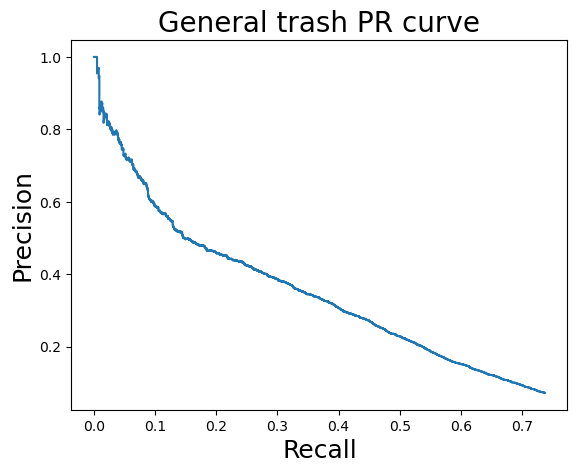

General trash | 0.264624 |    3966


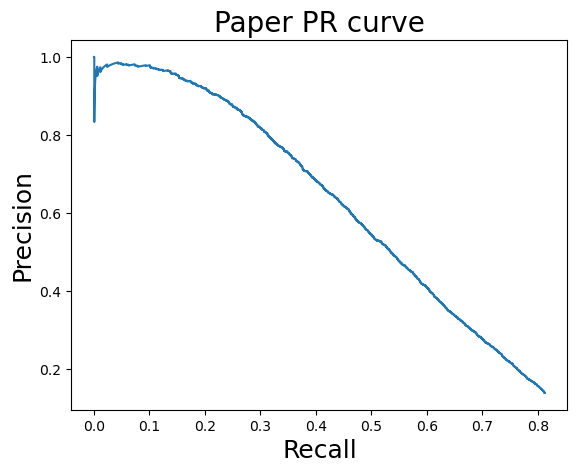

Paper      | 0.522890 |    6352


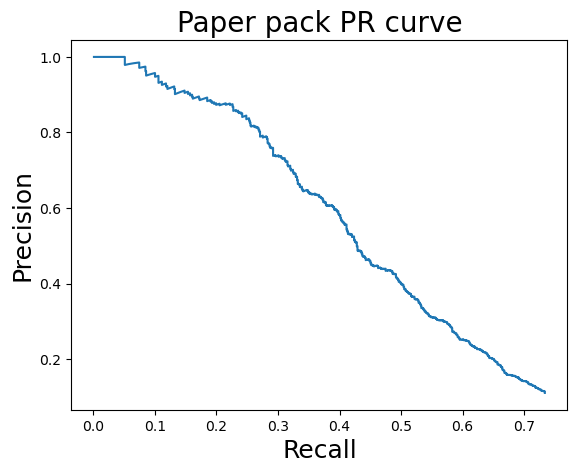

Paper pack | 0.441265 |     897


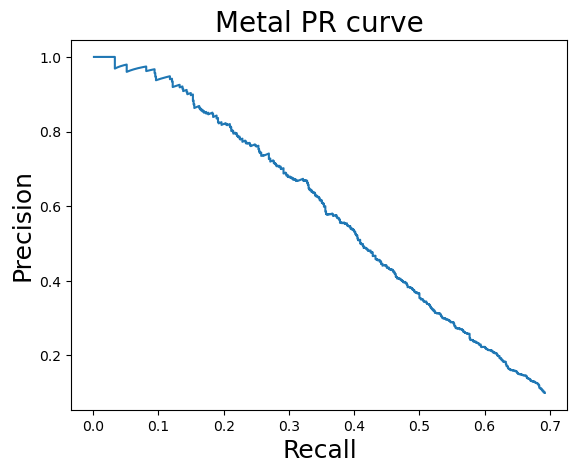

Metal      | 0.411529 |     936


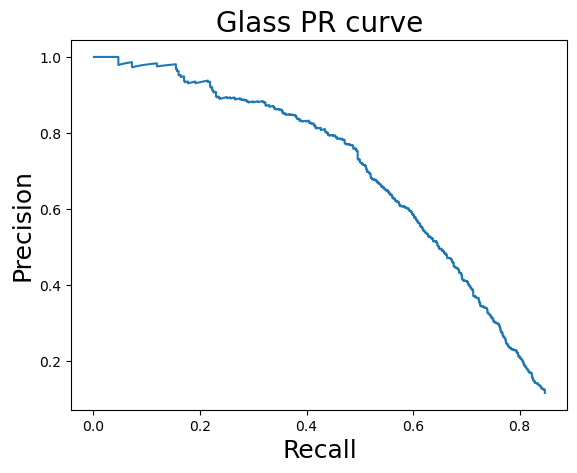

Glass      | 0.604017 |     982


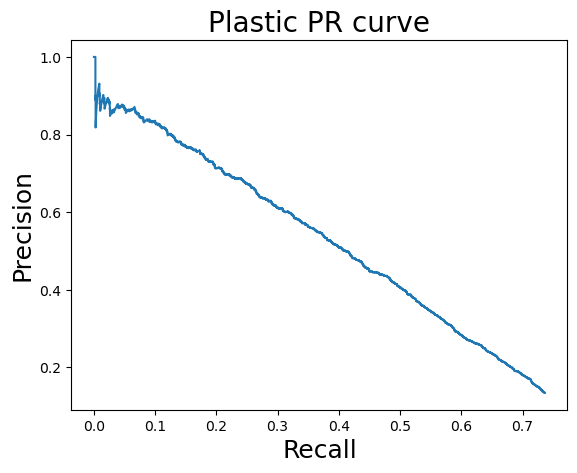

Plastic    | 0.397688 |    2943


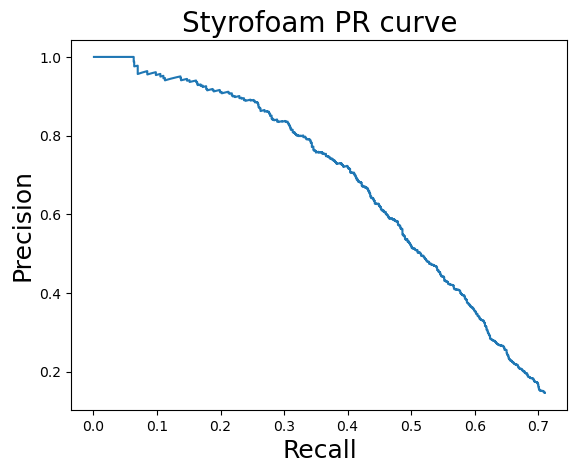

Styrofoam  | 0.490678 |    1263


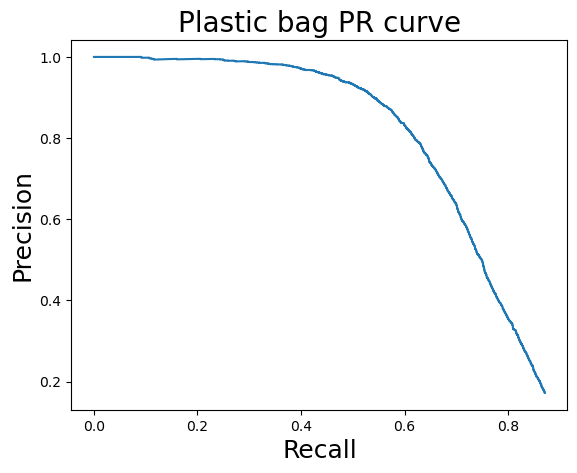

Plastic bag | 0.722987 |    5178


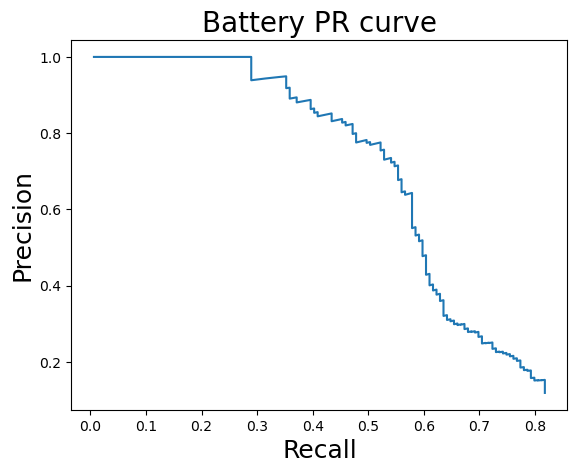

Battery    | 0.599785 |     159


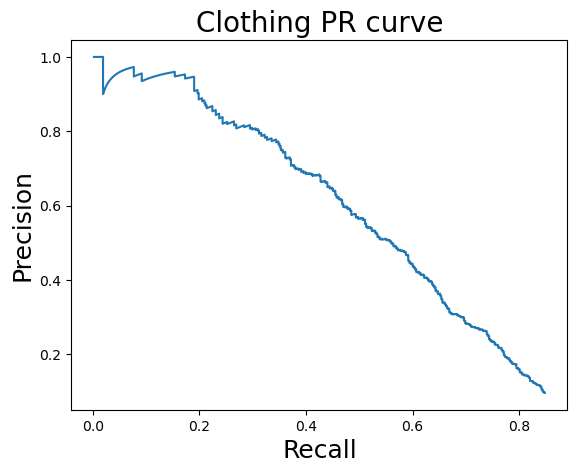

Clothing   | 0.531735 |     468
mAP: 0.498720
0.49871974228579613


In [18]:
'''
calculate mAP
'''

mean_ap, average_precisions = mean_average_precision_for_boxes(gt, new_pred, iou_threshold=0.5)

print(mean_ap)

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.
